In [1]:
%load_ext watermark


In [2]:
import os

from IPython.display import display
import itertools as it
import matplotlib.ticker as mpl_ticker
import outset as otst
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-01-23T00:44:31.320084+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot   : 1.2.0
seaborn   : 0.13.2
outset    : 0.1.9
matplotlib: 3.9.2
pandas    : 2.2.3
polars    : 1.9.0

Watermark: 2.4.3



In [4]:
teeplot_subdir = os.environ.get("NOTEBOOK_NAME", "2025-01-18-cpp-bench-speed")
teeplot_subdir


'2025-01-18-cpp-bench-speed'

## Prep Data


In [5]:
df = pl.concat(
    [
        pl.read_csv("https://osf.io/m6wne/download"),
        pl.read_csv("https://osf.io/sb4zw/download"),
    ],
)
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .with_columns(
        duration_per_item_ns=(
            pl.col("duration_s") * 1_000_000_000 / pl.col("num_items")
        )
    )
    .filter(pl.col("algo_name") != "naive_steady_algo")
    .with_columns(
        algo_name=pl.col("algo_name").replace(
            {"zhao_steady_algo": "naive_steady_algo"},
        ),
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            {
                "control_ring_algo": "\u200bcontrol: ringbuf",
                "control_throwaway_algo": "\u200bcontrol: discard",
                "dstream.steady_algo": "dstream steady",
                "dstream.stretched_algo": "dstream stretched",
                "dstream.tilted_algo": "dstream tilted",
                "naive_steady_algo": "naive steady",
                "zhao_tilted_algo": "naive tilted",
                # "zhao_steady_algo": "zhao steady",
            }.__getitem__,
            return_dtype=str,
        )
    )
)

display(df.describe()), display(df.head()), display(df.tail());


statistic,algo_name,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm
str,str,str,f64,f64,f64,f64,f64,f64,str
"""count""","""3360""","""3360""",3360.0,3360.0,3360.0,3360.0,3360.0,3360.0,"""3360"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,null,951.190476,370000.0,1360.0,9.5,0.005601,62.384845,null
"""std""",null,null,3180.661267,447056.463983,1620.196674,5.76714,0.020233,392.890197,null
"""min""","""control_ring_algo""","""clang++""",12.0,10000.0,64.0,0.0,0.000019,1.8498,"""dstream steady"""
"""25%""",null,null,36.0,10000.0,256.0,5.0,0.00013,1.942506,null
"""50%""",null,null,132.0,100000.0,1024.0,10.0,0.000619,4.493915,null
"""75%""",null,null,516.0,1e6,1024.0,14.0,0.003125,12.5763,null
"""max""","""zhao_tilted_algo""","""g++""",16960.0,1e6,4096.0,19.0,0.209822,4680.4235,"""​control: ringbuf"""


algo_name,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm
str,str,i32,i32,i32,i32,f64,f64,str
"""control_ring_algo""","""clang++""",12,10000,64,0,0.000019,1.8756,"""​control: ringbuf"""
"""control_ring_algo""","""clang++""",12,10000,64,1,0.000019,1.8755,"""​control: ringbuf"""
"""control_ring_algo""","""clang++""",12,10000,64,2,0.000019,1.8756,"""​control: ringbuf"""
"""control_ring_algo""","""clang++""",12,10000,64,3,0.000019,1.8665,"""​control: ringbuf"""
"""control_ring_algo""","""clang++""",12,10000,64,4,0.000019,1.8655,"""​control: ringbuf"""


algo_name,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm
str,str,i32,i32,i32,i32,f64,f64,str
"""zhao_tilted_algo""","""g++""",143,1000000,4096,15,0.013005,13.004743,"""naive tilted"""
"""zhao_tilted_algo""","""g++""",143,1000000,4096,16,0.013032,13.032135,"""naive tilted"""
"""zhao_tilted_algo""","""g++""",143,1000000,4096,17,0.013003,13.003431,"""naive tilted"""
"""zhao_tilted_algo""","""g++""",143,1000000,4096,18,0.013017,13.017118,"""naive tilted"""
"""zhao_tilted_algo""","""g++""",143,1000000,4096,19,0.013011,13.011486,"""naive tilted"""


## Plot


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=compiler+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=compiler+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.png


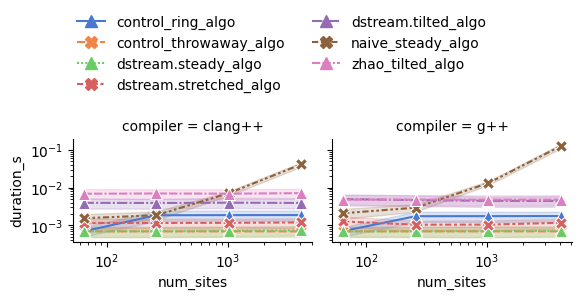

In [6]:
with tp.teed(
    sns.relplot,
    data=df,
    x="num_sites",
    y="duration_s",
    col="compiler",
    hue="algo_name",
    style="algo_name",
    palette="muted",
    kind="line",
    aspect=1.5,
    markers=["^", "X"],
    ms=8,
    height=2,
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(xscale="log", yscale="log")
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.35, 1),
        ncol=2,
        title=None,
        frameon=False,
    )
    g.tight_layout()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=algorithm+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=algorithm+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.png


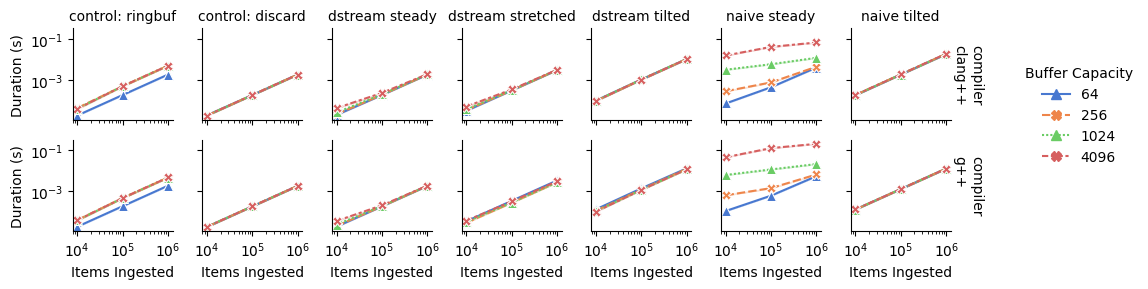

In [7]:
with tp.teed(
    sns.relplot,
    data=df.with_columns(
        pl.col("num_sites").alias("Buffer Capacity"),
    ),
    x="num_items",
    y="duration_s",
    col="algorithm",
    row="compiler",
    hue="Buffer Capacity",
    style="Buffer Capacity",
    facet_kws=dict(margin_titles=True),
    palette="muted",
    kind="line",
    aspect=1,
    markers=["^", "X"],
    ms=7,
    height=1.5,
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(xscale="log", yscale="log")
    g.set_titles(
        col_template="{col_name}",
        row_template="{row_var}\n{row_name}",
    )
    g.set_xlabels("Items Ingested")
    g.set_ylabels("Duration (s)")
    sns.move_legend(
        g,
        "upper left",
        bbox_to_anchor=(0.87, 0.8),
        ncol=1,
        title="Buffer Capacity",
        frameon=False,
    )
    g.tight_layout()


num_items=10000, exclude=


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4523/2658157826.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


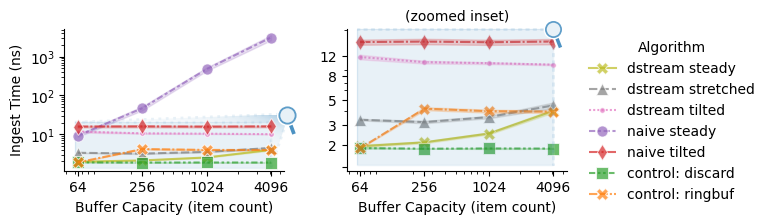

num_items=10000, exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4523/2658157826.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


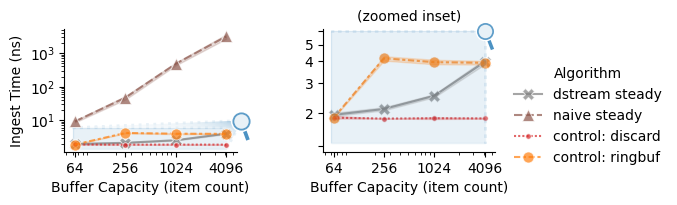

num_items=1000000, exclude=


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4523/2658157826.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


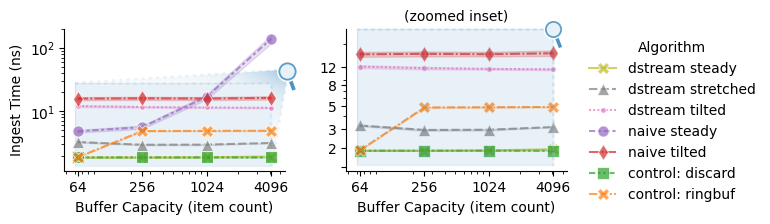

num_items=1000000, exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4523/2658157826.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


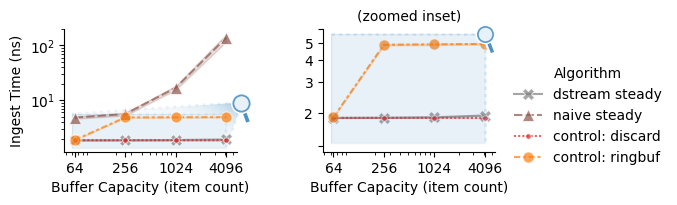

In [8]:
for num_items, exclude in it.product(
    [10_000, 1_000_000],
    ["", "dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo"],
):
    print(f"num_items={num_items}, exclude={exclude}")
    data = (
        df.with_columns(
            is_naive=pl.col("algo_name") == "naive_steady_algo",
        )
        .filter(pl.col("num_items") == num_items)
        .filter(~pl.col("algo_name").is_in(exclude.split(",")))
        .sort(
            "algorithm",
        )
        .to_pandas()
        .astype(
            {"algorithm": "category"},
        )
    )
    with tp.teed(
        otst.OutsetGrid,
        data=data,
        x="num_sites",
        y="duration_per_item_ns",
        row="is_naive",
        row_order=[False],
        marqueeplot_kws=dict(
            frame_outer_pad=(4.0, 0.2),
            frame_inner_pad=(4.0, 0.5),
            leader_stretch=0.8,
            frame_edge_kws={"alpha": 0.1},
            leader_edge_kws={"alpha": 0.1},
        ),
        height=2.2 if exclude else 2.5,
        aspect=1.2,
        palette="tab10_r",
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs=dict(exclude=exclude, num_items=num_items),
    ) as g:
        g.map_dataframe(
            sns.lineplot,
            x="num_sites",
            y="duration_per_item_ns",
            alpha=0.7,
            hue="algorithm",
            style="algorithm",
            style_order=sorted(data["algorithm"].unique()),
            markers=["X", "^", ".", "o", "d", "s"],
            ms=8,
            palette="tab10_r",
            zorder=otst.util.SplitKwarg(None, -1),
        )
        g.set(xlim=(32 * 1.5, 8192 / 1.5), xscale="log", yscale="log")
        g.marqueeplot(equalize_aspect=False)
        g.set(xlim=(32 * 1.5, 8192 / 1.5), xscale="log", yscale="log")
        g.set_xlabels("Buffer Capacity (item count)")
        g.set_ylabels("Ingest Time (ns)")
        yticks = [1.3, 2, 3, 5, 8, 12]
        ytick_labels = [" ", "2", "3", "5", "8", "12"]
        g.tight_layout()
        g.add_legend(title="Algorithm", bbox_to_anchor=(1.02, 0.45))
        ax = g.axes.flat[1]
        ax.set_ylim(1.2, None)
        ax.set_title("(zoomed inset)", size=10)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        empty_string_labels = [""] * len(labels)
        ax.set_xticklabels(empty_string_labels)
        if exclude:
            yticks = [1.3, 2, 3, 4, 5, 6]
            ytick_labels = ["", "2", "3", "4", "5", " "]
        ax.yaxis.set_major_locator(mpl_ticker.FixedLocator(yticks))
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        g.set(
            xticks=[64, 256, 1024, 4096],
            xticklabels=["64", "256", "1024", "4096"],
        )


/tmp/ipykernel_4523/2536969235.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


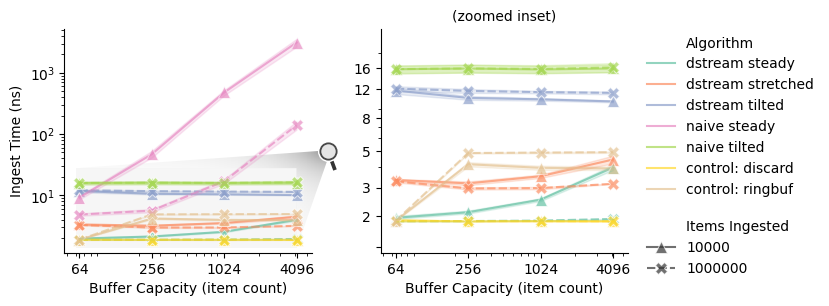

/tmp/ipykernel_4523/2536969235.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


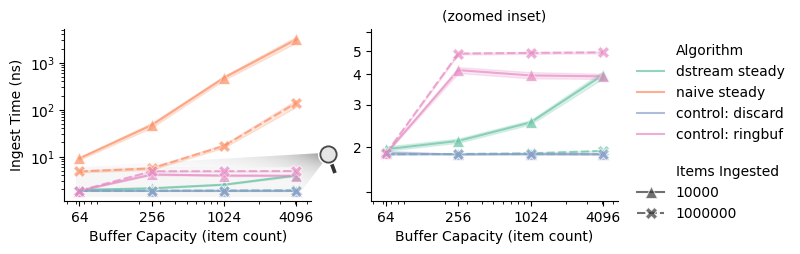

In [9]:
for exclude in (
    "",
    "dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo",
):
    data = (
        df.with_columns(
            is_naive=pl.col("algo_name") == "naive_steady_algo",
        )
        .with_columns(
            pl.col("num_items").alias("\nItems Ingested"),
            pl.col("algorithm").alias("Algorithm"),
        )
        .filter(pl.col("num_items").is_in([10_000, 1_000_000]))
        .filter(~pl.col("algo_name").is_in(exclude.split(",")))
        .sort(
            "algorithm",
        )
        .to_pandas()
        .astype(
            {"algorithm": "category"},
        )
    )
    with tp.teed(
        otst.OutsetGrid,
        data=data,
        color="black",
        x="num_sites",
        y="duration_per_item_ns",
        row="is_naive",
        row_order=[False],
        marqueeplot_kws=dict(
            # mark_glyph=otst.mark.MarkInlaidAsterisk(),
            frame_outer_pad=(4.0, 0.2),
            frame_inner_pad=(4.0, 0.5),
            leader_stretch=1.8,
        ),
        marqueeplot_source_kws=dict(
            leader_face_kws={"alpha": 0.5, "zorder": -2},
            frame_edge_kws={"alpha": 0.0},
            leader_edge_kws={"alpha": 0.0},
            frame_face_kws={"alpha": 0.07, "facecolor": "gray", "zorder": -2},
            zorder=100,
        ),
        marqueeplot_outset_kws=dict(
            frame_face_kws={"facecolor": "none"},
            frame_edge_kws={"alpha": 0.0},
            leader_edge_kws={"alpha": 0.0},
            mark_glyph=None,
        ),
        height=2.7 if exclude else 3.3,
        aspect=1.2 if exclude else 1,
        palette="tab10_r",
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs=dict(exclude=exclude),
    ) as g:
        g.map_dataframe(
            sns.lineplot,
            x="num_sites",
            y="duration_per_item_ns",
            alpha=0.7,
            hue="Algorithm",
            style="\nItems Ingested",
            style_order=sorted(data["num_items"].unique()),
            markers=["^", "X"],
            ms=8,
            palette="Set2",
            zorder=otst.util.SplitKwarg(-1, -1),
        )
        g.set(xlim=(32 * 1.5, 8192 / 1.5), xscale="log", yscale="log")
        g.marqueeplot(
            equalize_aspect=False,
        )
        g.set(xlim=(32 * 1.5, 8192 / 1.5), xscale="log", yscale="log")
        g.set_xlabels("Buffer Capacity (item count)")
        g.set_ylabels("Ingest Time (ns)")
        yticks = [1.3, 2, 3, 5, 8, 12, 16]
        ytick_labels = [" ", "2", "3", "5", "8", "12", "16"]
        g.tight_layout()
        ax = g.axes.flat[1]
        ax.set_ylim(1.2, None)
        ax.set_title("(zoomed inset)", size=10)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        empty_string_labels = [""] * len(labels)
        ax.set_xticklabels(empty_string_labels)
        if exclude:
            yticks = [1.3, 2, 3, 4, 5, 6]
            ytick_labels = ["", "2", "3", "4", "5", " "]
        ax.yaxis.set_major_locator(mpl_ticker.FixedLocator(yticks))
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        g.set(
            xticks=[64, 256, 1024, 4096],
            xticklabels=["64", "256", "1024", "4096"],
        )
        g.tight_layout()
        g.add_legend(bbox_to_anchor=(1.015, 0.47))


,num_sites,algo_name,speedup_mean,speedup_std
0,64,control_ring_algo,2.561356,0.365575
1,256,control_ring_algo,1.159075,0.266174
2,1024,control_ring_algo,3.482408,1.079096
3,4096,control_ring_algo,28.654331,15.409397
4,64,control_throwaway_algo,2.585976,0.390502
5,256,control_throwaway_algo,2.999371,0.606713
6,1024,control_throwaway_algo,9.034914,2.532378
7,4096,control_throwaway_algo,74.400535,38.338951
8,64,dstream.steady_algo,2.584151,0.390162
9,256,dstream.steady_algo,2.997225,0.607461


,num_sites,algo_name,speedup_mean,speedup_std
0,64,control_ring_algo,4.864644,1.023498
1,256,control_ring_algo,11.505547,4.986920
2,1024,control_ring_algo,122.544837,44.280971
3,4096,control_ring_algo,799.294670,401.809821
4,64,control_throwaway_algo,4.874724,1.097741
5,256,control_throwaway_algo,25.078330,9.838650
6,1024,control_throwaway_algo,253.843284,82.383970
7,4096,control_throwaway_algo,1668.592355,832.505999
8,64,dstream.steady_algo,4.714322,1.115808
9,256,dstream.steady_algo,22.383599,9.408473


teeplots/2025-01-18-cpp-bench-speed/col=compiler+hue=algo-name+kind=bar+viz=catplot+x=num-sites+y=speedup+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=compiler+hue=algo-name+kind=bar+viz=catplot+x=num-sites+y=speedup+ext=.png


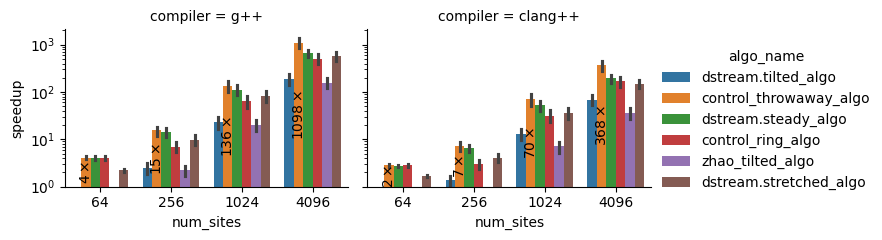

In [10]:
# 1) Compute mean duration per group x algo
df_agg = df.group_by(
    ["compiler", "num_items", "num_sites", "replicate", "algo_name"]
).agg(mean_duration_s=pl.col("duration_s").mean())

# 2) Compute mean duration *just for* "naive_steady_algo"
df_naive = (
    df.filter(pl.col("algo_name") == "naive_steady_algo")
    .group_by(["compiler", "num_items", "num_sites", "replicate"])
    .agg(naive_mean_duration_s=pl.col("duration_s").mean())
)

# 3) Join the two on compiler,num_items,num_sites,replicate
df_speedup = df_agg.join(
    df_naive,
    on=["compiler", "num_items", "num_sites", "replicate"],
    how="left",
).with_columns(
    # 4) Speedup = ratio vs. naive_steady_algo
    (pl.col("naive_mean_duration_s") / pl.col("mean_duration_s")).alias(
        "speedup"
    )
)

# Display tabular results
with pd.option_context("display.max_columns", None):
    with pd.option_context("display.max_rows", None):
        display(
            df_speedup.filter(pl.col("num_items") == 1_000_000)
            .group_by(["num_sites", "algo_name"])
            .agg(
                speedup_mean=pl.col("speedup").mean(),
                speedup_std=pl.col("speedup").std(),
            )
            .sort(["algo_name", "num_sites"])
            .to_pandas()
        )

# Display tabular results
with pd.option_context("display.max_columns", None):
    with pd.option_context("display.max_rows", None):
        display(
            df_speedup.filter(pl.col("num_items") == 10_000)
            .group_by(["num_sites", "algo_name"])
            .agg(
                speedup_mean=pl.col("speedup").mean(),
                speedup_std=pl.col("speedup").std(),
            )
            .sort(["algo_name", "num_sites"])
            .to_pandas()
        )

# Now plot speedup on a log scale
with tp.teed(
    sns.catplot,
    data=df_speedup.cast({"num_sites": str}).filter(
        pl.col("algo_name") != "naive_steady_algo"
    ),
    x="num_sites",
    y="speedup",
    order=list(map(str, sorted(df_speedup["num_sites"].unique()))),
    hue="algo_name",
    col="compiler",
    kind="bar",
    aspect=1.4,
    height=2.5,
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(yscale="log", ylim=(1, None))
    for ax in g.axes.flat:
        ax.bar_label(
            ax.containers[1],
            fmt="$%d\\times$",
            label_type="center",
            rotation=90,
        )
